# Toy Problem Optimization

This notebook explores what happens when you take the two-link rope toy problem and pull the rope only towards increase X, which is easy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, precision=2)
from link_bot_notebooks import toy_problem_optimization_common as tpo
np.random.seed(0)

In [2]:
from IPython.display import display, Markdown, Pretty, HTML
def BOLD(x):
    display(Markdown("**" + str(x) + "**"))


### Define goal

Our goal will be denoted as $g$, for now we simply assume its defined in the full state space

In [3]:
g = np.array([[5], [0], [6], [0]])

# Manual Data

Let's pretend our data comes from pulling a 2-link object to the right for 6 time steps

In [4]:
manual_data = []
manual_dt = 0.1
for x1 in np.arange(0, 5, manual_dt):
    y = 0 #np.random.randint(-10,10)
    # Training data looks like [(s_t, u_t, s_{t+1}, c_t, c_{t+1})]
    manual_data.append((np.array([[x1],[y],[x1+1],[y]]),
         np.array([[1],[0]]),
         np.array([[x1+manual_dt],[y],[x1+1+manual_dt],[y]]),
         np.array([[(g[0] - x1)**2]]),
         np.array([[(g[0] - (x1+manual_dt))**2]])))

### X Model (Perfect)

This model reduces the full state to just $x_1$. The dynamics are $\dot{o}=v_x$, and the cost is simply the squared difference $(g - x_1)^2$

In [5]:
x_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=1, L=2)
x_model.from_params([1, 0, 0, 0, 0, 1, 0, 1])
BOLD("X Model Loss:")
x_eval = tpo.eval_model(x_model, manual_data, g, manual_dt, print_model=False)

**X Model Loss:**

Loss Components:
	current cost: 0.0
	predict next latent state: 0.0
	predict next cost: 0.0
	regularization: 1.73205080757e-05
Complete Losses:
	predict next latent state and current cost: 1.73205080757e-05
	predict next cost and current cost: 1.73205080757e-05



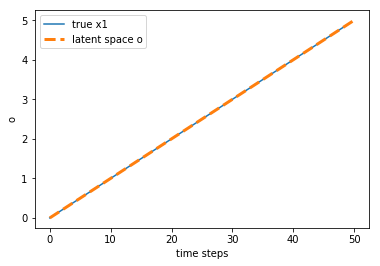

('Predicted cost of rollout', array([[429.25]]))


In [6]:
s0 = np.array([[0], [0], [1], [0]])
x_model_rollout_predicted_cost = tpo.plot_x_rollout(plt, x_model, manual_data, manual_dt, s0, g)
print("Predicted cost of rollout", x_model_rollout_predicted_cost)

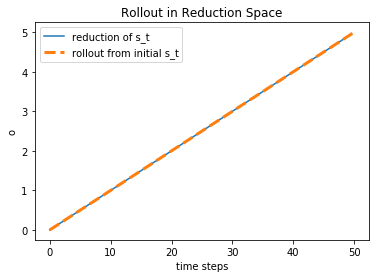

In [7]:
tpo.plot_o_rollout(plt, x_model, manual_data, manual_dt, g)

### Model with all zeros

We expect this to be bad

In [8]:
zero_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=1, L=2)
zero_model.from_params(np.zeros(8))
BOLD("Zero Model Loss:")
zero_eval = tpo.eval_model(zero_model, manual_data, g, manual_dt, print_model=False)

**Zero Model Loss:**

Loss Components:
	current cost: 131.33333
	predict next latent state: 0.0
	predict next cost: 118.83333
	regularization: 0.0
Complete Losses:
	predict next latent state and current cost: 65.666665
	predict next cost and current cost: 125.08333



### Y Model

reduces to just $y_1$, and says $\dot{o}=v_y$, and cost is $(g-y_1)^2$

we expect this to be bad.

In [9]:
y_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=1, L=2)
y_model.from_params([0, 1, 0, 0, 0, 0, 1, 1])
BOLD("Y Model Loss:")
y_eval = tpo.eval_model(y_model, manual_data, g, manual_dt, print_model=False)

**Y Model Loss:**

Loss Components:
	current cost: 131.33333
	predict next latent state: 0.0
	predict next cost: 118.83333
	regularization: 1.73205080757e-05
Complete Losses:
	predict next latent state and current cost: 65.6666823205
	predict next cost and current cost: 125.083347321



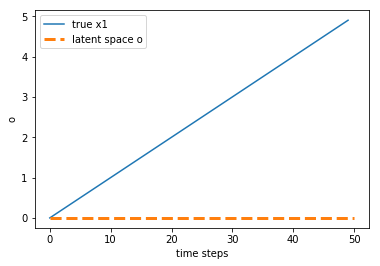

('Predicted cost of rollout', array([[0.]]))


In [10]:
s0 = np.array([[0], [0], [1], [0]])
y_model_rollout_predicted_cost = tpo.plot_x_rollout(plt, y_model, manual_data, manual_dt, s0, g)
print("Predicted cost of rollout", y_model_rollout_predicted_cost)

### Random Models (average)

In [11]:
N = 1000
costs = np.zeros(N)
random_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=1, L=2)
for i in range(N):
    random_params = np.random.randn(8)
    random_model.from_params(random_params)
    costs[i] = tpo.state_prediction_objective(random_model, g, manual_data, manual_dt)
print("Median cost for random parameters {:.3f}".format(np.median(costs)))

Median cost for random parameters 75.125


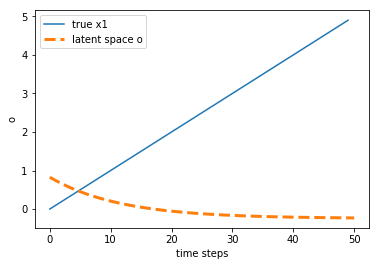

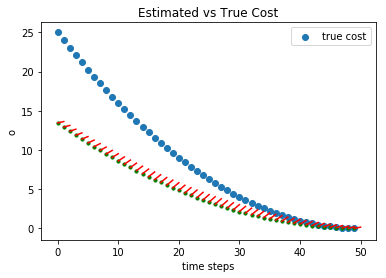

In [12]:
s0 = np.array([[0], [0], [1], [0]])
tpo.plot_x_rollout(plt, random_model, manual_data, manual_dt, s0, g)
tpo.plot_cost(plt, random_model, manual_data, manual_dt, g)

### Trained  Model (C Loss)

This should **NOT** work well

In [13]:
c_manual_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=1, L=2)
BOLD("C Manual Model Loss:")
c_manual_eval = tpo.train_and_eval(c_manual_model, manual_data, g, manual_dt, tpo.cost_prediction)

**C Manual Model Loss:**

Finished in 16 iterations
Loss Components:
	current cost: 3.1376654853
	predict next latent state: 0.000313405863223
	predict next cost: 2.8777657939e-21
	regularization: 0.0019649319238
Complete Losses:
	predict next latent state and current cost: 1.5709543775
	predict next cost and current cost: 1.57079767457

Model reduction Matrix: [[-0.85 59.65  0.92 60.86]]
 Dynamics matrices: [[0.88]], [[-1.04 57.98]]
 Cost Matrix: [[167.28]]


### Trained  Model (CSP Loss)

In [14]:
csp_manual_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=1, L=2)
BOLD("CSP Manual Model Loss:")
csp_manual_eval = tpo.train_and_eval(csp_manual_model, manual_data, g, manual_dt, tpo.state_prediction_objective)
# csp_manual_0_eval = tpo.train_and_eval(csp_manual_model, manual_data, g, manual_dt, tpo.state_prediction_objective, tpo.ZEROS)

**CSP Manual Model Loss:**

Finished in 3 iterations
Loss Components:
	current cost: 1.81011784452e-11
	predict next latent state: 8.63864458421e-07
	predict next cost: 5.2844926992e-05
	regularization: 1.93180440434e-05
Complete Losses:
	predict next latent state and current cost: 1.97499853232e-05
	predict next cost and current cost: 4.574051659e-05

Model reduction Matrix: [[-1.31 -0.    0.29 -0.  ]]
 Dynamics matrices: [[0.01]], [[-1. -0.]]
 Cost Matrix: [[0.97]]


### Apply learned model given the actions we trained on, starting at the same initial state

Consider what happens if we follow a plan of pulling in positive X from the origin?
The true cost is the sum: $(5-0)^2+(5-0.1)^2+\dots+(5-4.9)^2+(5-5)^2$

In [15]:
# This is what we know the cost will be...
cost = 0
for x1 in np.arange(0, 5, .1):
    cost += (5-x1)**2
print(cost)

429.25000000000006


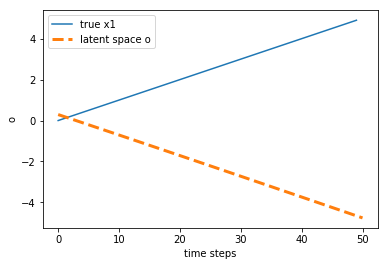

('Predicted cost of rollout', array([[434.18]]))


In [16]:
s0 = np.array([[0], [0], [1], [0]])
csp_manual_model_rollout_predicted_cost = tpo.plot_x_rollout(plt, csp_manual_model, manual_data, manual_dt, s0, g)
print("Predicted cost of rollout", csp_manual_model_rollout_predicted_cost)

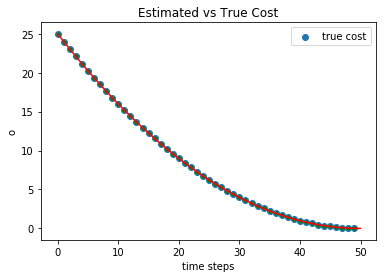

In [17]:
tpo.plot_cost(plt, csp_manual_model, manual_data, manual_dt, g)

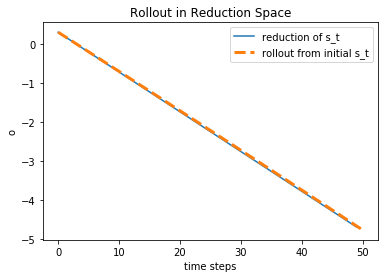

In [18]:
tpo.plot_o_rollout(plt, csp_manual_model, manual_data, manual_dt, g)

### Trained  Model (CCP Loss)

In [19]:
ccp_manual_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=1, L=2)
BOLD("CCP Manual Model Loss:")
ccp_manual_eval = tpo.train_and_eval(ccp_manual_model, manual_data, g, manual_dt, tpo.cost_prediction_objective)
# ccp_manual_0_eval = tpo.train_and_eval(ccp_manual_model, manual_data, g, manual_dt, tpo.one_step_cost_prediction_objective, tpo.ZEROS)

**CCP Manual Model Loss:**

Finished in 7 iterations
Loss Components:
	current cost: 1.90708622371e-08
	predict next latent state: 2.36669322455e-09
	predict next cost: 3.42879334463e-08
	regularization: 1.64027305152e-05
Complete Losses:
	predict next latent state and current cost: 1.6413449293e-05
	predict next cost and current cost: 1.64294099131e-05

Model reduction Matrix: [[-0.8  -0.   -0.19 -0.  ]]
 Dynamics matrices: [[0.]], [[-0.99 -0.  ]]
 Cost Matrix: [[1.02]]


### Apply learned model given the actions we trained on, starting at the same initial state

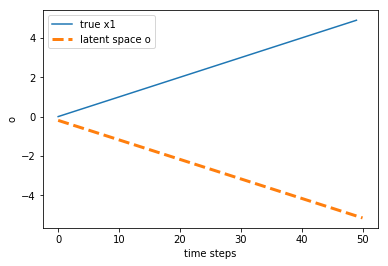

('Predicted cost of rollout', array([[429.41]]))


In [20]:
s0 = np.array([[0], [0], [1], [0]])
ccp_manual_model_rollout_predicted_cost = tpo.plot_x_rollout(plt, ccp_manual_model, manual_data, manual_dt, s0, g)
print("Predicted cost of rollout", ccp_manual_model_rollout_predicted_cost)

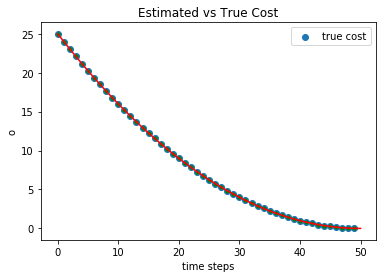

In [21]:
tpo.plot_cost(plt, ccp_manual_model, manual_data, manual_dt, g)

# Now with some data from Gazebo

In [22]:
gazebo_fwd_data = tpo.load_data("/home/pmitrano/catkin_ws/src/link_bot/link_bot_teleop/data/fwd_1.txt", g, extract_func=tpo.one_link_pos_extractor)
gazebo_dt = 0.1

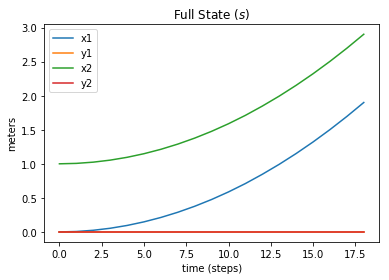

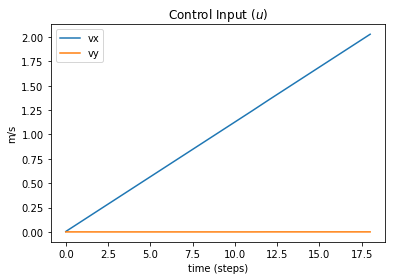

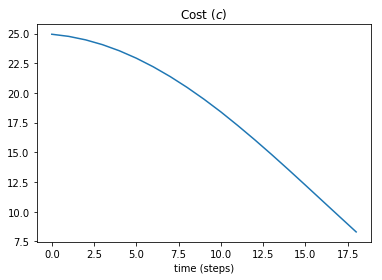

In [23]:
tpo.plot_gz_data(plt, gazebo_fwd_data)

### See how our previous model reduction transfers

To use the same models, the dimensionality of the input data must be the same.

In [24]:
print("Use the models trained on manual synthetic data, test on new Gazebo pull data")
BOLD("CSP Model")
csp_manual_eval_on_gz = tpo.eval_model(csp_manual_model, gazebo_fwd_data, g, gazebo_dt, print_model=False)
BOLD("CCP Model")
ccp_manual_eval_on_gz = tpo.eval_model(ccp_manual_model, gazebo_fwd_data, g, gazebo_dt, print_model=False)

Use the models trained on manual synthetic data, test on new Gazebo pull data


**CSP Model**

Loss Components:
	current cost: 6.81688069265e-06
	predict next latent state: 0.000145363228211
	predict next cost: 0.00924793511485
	regularization: 1.93180440434e-05
Complete Losses:
	predict next latent state and current cost: 9.54080984952e-05
	predict next cost and current cost: 0.00464669404182



**CCP Model**

Loss Components:
	current cost: 3.83647211068e-06
	predict next latent state: 0.000106038456474
	predict next cost: 0.00643754617166
	regularization: 1.64027305152e-05
Complete Losses:
	predict next latent state and current cost: 7.13401948076e-05
	predict next cost and current cost: 0.0032370940524



### Apply model trained on manual data to gazebo actions

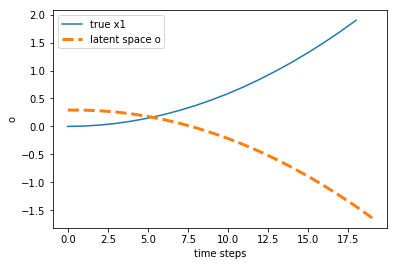

('Predicted cost using CSP Manual Model of rollout in Gazebo', array([[378.85]]))


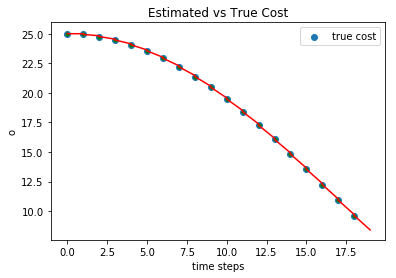

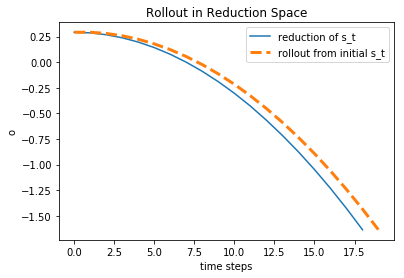

In [25]:
s0 = np.array([[0], [0], [1], [0]])
csp_manual_model_gz_rollout_predicted_cost = tpo.plot_x_rollout(plt, csp_manual_model, gazebo_fwd_data, gazebo_dt, s0, g)
print("Predicted cost using CSP Manual Model of rollout in Gazebo", csp_manual_model_gz_rollout_predicted_cost)
tpo.plot_cost(plt, csp_manual_model, gazebo_fwd_data, gazebo_dt, g)
tpo.plot_o_rollout(plt, csp_manual_model, gazebo_fwd_data, gazebo_dt, g)

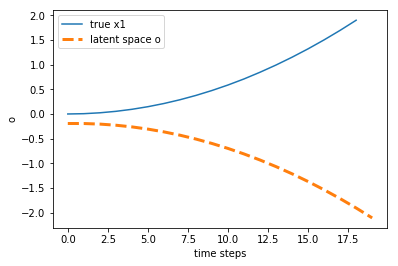

('Predicted cost using CCP Manual Model of rollout in Gazebo', array([[377.44]]))


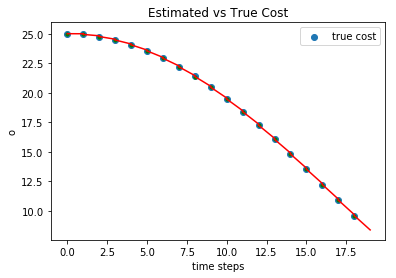

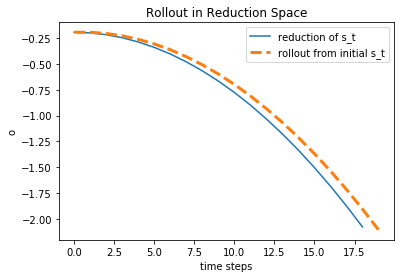

In [26]:
s0 = np.array([[0], [0], [1], [0]])
ccp_manual_model_gz_rollout_predicted_cost = tpo.plot_x_rollout(plt, ccp_manual_model, gazebo_fwd_data, gazebo_dt, s0, g)
print("Predicted cost using CCP Manual Model of rollout in Gazebo", ccp_manual_model_gz_rollout_predicted_cost)
tpo.plot_cost(plt, ccp_manual_model, gazebo_fwd_data, gazebo_dt, g)
tpo.plot_o_rollout(plt, ccp_manual_model, gazebo_fwd_data, gazebo_dt, g)

### Show that our hand-designed parameters still work well

In [27]:
x_model_eval_on_gz = tpo.eval_model(x_model, gazebo_fwd_data, g, gazebo_dt, print_model=False)

Loss Components:
	current cost: 1.23233491903e-21
	predict next latent state: 0.000105890090813
	predict next cost: 0.00665077485705
	regularization: 1.73205080757e-05
Complete Losses:
	predict next latent state and current cost: 7.0265553482e-05
	predict next cost and current cost: 0.0033427079366



### Try to optimize on our new data

First with the CSP Loss Function

In [28]:
csp_gz_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=1, L=2)
BOLD("Gazebo CSP")
csp_gz_eval = tpo.train_and_eval(csp_gz_model, gazebo_fwd_data, g, gazebo_dt, tpo.state_prediction_objective)

**Gazebo CSP**

Finished in 6 iterations
Loss Components:
	current cost: 1.98853286909e-05
	predict next latent state: 1.77864377066e-05
	predict next cost: 0.000431549230828
	regularization: 2.07911728707e-05
Complete Losses:
	predict next latent state and current cost: 3.96270560695e-05
	predict next cost and current cost: 0.00024650845263

Model reduction Matrix: [[ 0.42 -0.    1.3  -0.  ]]
 Dynamics matrices: [[0.15]], [[ 1.52 -0.  ]]
 Cost Matrix: [[0.34]]


In [29]:
BOLD("Gazebo CSP (Meta)")
csp_gz_meta_eval = tpo.train_and_eval(csp_gz_model, gazebo_fwd_data, g, gazebo_dt, tpo.state_prediction_objective, initial_params=csp_manual_model.to_params())
# csp_gz_0_eval = tpo.train_and_eval(csp_gz_model, gazebo_fwd_data, g, gazebo_dt, tpo.state_prediction_objective, tpo.ZEROS)

**Gazebo CSP (Meta)**

Finished in 3 iterations
Loss Components:
	current cost: 2.88518060262e-06
	predict next latent state: 3.40467057271e-06
	predict next cost: 0.000279415183842
	regularization: 1.99767628784e-05
Complete Losses:
	predict next latent state and current cost: 2.31216884661e-05
	predict next cost and current cost: 0.000161126945101

Model reduction Matrix: [[-1.31 -0.    0.29 -0.  ]]
 Dynamics matrices: [[-0.05]], [[-1.12  0.  ]]
 Cost Matrix: [[0.97]]


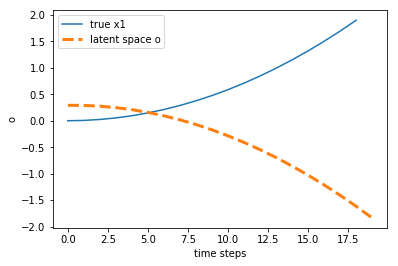

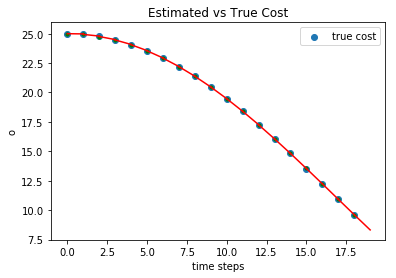

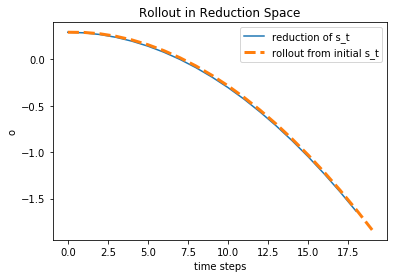

In [30]:
s0 = np.array([[0], [0], [1], [0]])
tpo.plot_x_rollout(plt, csp_gz_model, gazebo_fwd_data, gazebo_dt, s0, g)
tpo.plot_cost(plt, csp_gz_model, gazebo_fwd_data, gazebo_dt, g)
tpo.plot_o_rollout(plt, csp_gz_model, gazebo_fwd_data, gazebo_dt, g)

CCP Loss Function

In [31]:
ccp_gz_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=1, L=2)
BOLD("Gazebo CCP")
ccp_gz_eval = tpo.train_and_eval(ccp_gz_model, gazebo_fwd_data, g, gazebo_dt, tpo.cost_prediction_objective)
BOLD("Gazebo CCP (Meta)")
ccp_gz_meta_eval = tpo.train_and_eval(ccp_gz_model, gazebo_fwd_data, g, gazebo_dt, tpo.cost_prediction_objective, initial_params=ccp_manual_model.to_params())

**Gazebo CCP**

Status: 1, Message: Maximum number of function evaluations has been exceeded.
Loss Components:
	current cost: 0.025093006903
	predict next latent state: 1.19072762533e-06
	predict next cost: 0.00208566931074
	regularization: 0.00675285493968
Complete Losses:
	predict next latent state and current cost: 0.019299953755
	predict next cost and current cost: 0.0203421930465

Model reduction Matrix: [[  1.52 312.83  -1.56  48.38]]
 Dynamics matrices: [[0.01]], [[-0.03  6.83]]
 Cost Matrix: [[596.45]]


**Gazebo CCP (Meta)**

Finished in 23 iterations
Loss Components:
	current cost: 0.000158909846013
	predict next latent state: 8.89583007471e-06
	predict next cost: 0.000412599088814
	regularization: 1.69854202994e-05
Complete Losses:
	predict next latent state and current cost: 0.000100888258343
	predict next cost and current cost: 0.000302739887713

Model reduction Matrix: [[-0.8   0.   -0.19  0.  ]]
 Dynamics matrices: [[-0.02]], [[-1.08  0.04]]
 Cost Matrix: [[1.02]]


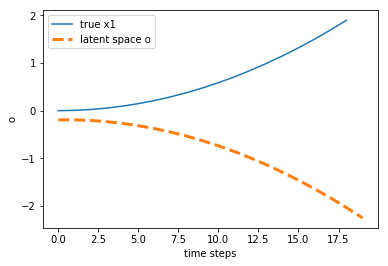

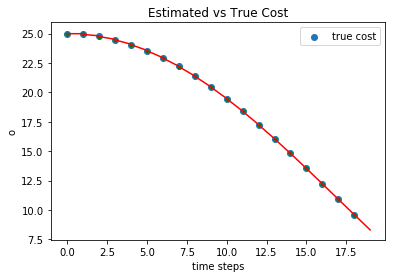

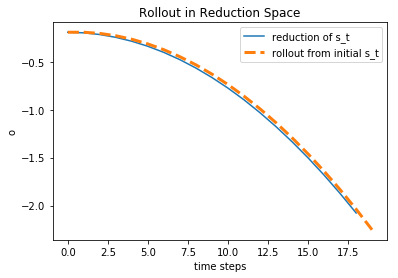

In [32]:
s0 = np.array([[0], [0], [1], [0]])
tpo.plot_x_rollout(plt, ccp_gz_model, gazebo_fwd_data, gazebo_dt, s0, g)
tpo.plot_cost(plt, ccp_gz_model, gazebo_fwd_data, gazebo_dt, g)
tpo.plot_o_rollout(plt, ccp_gz_model, gazebo_fwd_data, gazebo_dt, g)

# Summary of Results On The Gazebo Pull Data

How well do each of the models do on the Gazebo pull data?

Zero here is perfect.

### Hand-Picked

|Model|Current Cost Loss|Predict State Loss|Predict Cost Loss|Regularization Loss|
|-|-|-|-|-|
|Zero model|{{zero_eval[0]}}|{{zero_eval[1]}}|{{zero_eval[2]}}|{{zero_eval[3]}}|
|Y model|{{y_eval[0]}}|{{y_eval[1]}}|{{y_eval[2]}}|{{y_eval[3]}}|
|X model|{{x_eval[0]}}|{{x_eval[1]}}|{{x_eval[2]}}|{{x_eval[3]}}|

### Trained on CSP 

|Model|Current Cost Loss|Predict State Loss|Predict Cost Loss|Regularization Loss|
|-|-|-|-|-|
|Learned Manual model|{{csp_manual_eval[0]}}|{{csp_manual_eval[1]}}|{{csp_manual_eval[2]}}|{{csp_manual_eval[3]}}|
|Transfer Learned Manual model|{{csp_manual_eval_on_gz[0]}}|{{csp_manual_eval_on_gz[1]}}|{{csp_manual_eval_on_gz[2]}}|{{csp_manual_eval_on_gz[3]}}|
|Learned Gazebo model|{{csp_gz_eval[0]}}|{{csp_gz_eval[1]}}|{{csp_gz_eval[2]}}|{{csp_gz_eval[3]}}|
|Meta-Learned gz model|{{csp_gz_meta_eval[0]}}|{{csp_gz_meta_eval[1]}}|{{csp_gz_meta_eval[2]}}|{{csp_gz_meta_eval[3]}}|


### Trained on CCP 

|Model|Current Cost Loss|Predict State Loss|Predict Cost Loss|Regularization Loss|
|-|-|-|-|-|
|Learned Manual model|{{ccp_manual_eval[0]}}|{{ccp_manual_eval[1]}}|{{ccp_manual_eval[2]}}|{{ccp_manual_eval[3]}}|
|Transfer Learned Manual model|{{ccp_manual_eval_on_gz[0]}}|{{ccp_manual_eval_on_gz[1]}}|{{ccp_manual_eval_on_gz[2]}}|{{ccp_manual_eval_on_gz[3]}}|
|Learned Gazebo model|{{ccp_gz_eval[0]}}|{{ccp_gz_eval[1]}}|{{ccp_gz_eval[2]}}|{{ccp_gz_eval[3]}}|
|Meta-Learned gz model|{{ccp_gz_meta_eval[0]}}|{{ccp_gz_meta_eval[1]}}|{{ccp_gz_meta_eval[2]}}|{{ccp_gz_meta_eval[3]}}|

 - we are able to minimize these loss functions
 - therefore we do not drift from the state/action space of our training data and thus we do not drift
 - training routine is not reproducible. different random vector can give very different results